In [1]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
from PIL import Image
from mss import mss

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import pyautogui

env = gym.make('CartPole-v0').unwrapped

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Input Extraction(Screen Extraction)
from PIL import ImageGrab
import cv2

In [22]:
 def transform_screen_data(screen):
        screen = np.ascontiguousarray(screen, dtype=np.float32)/255
        screen = torch.from_numpy(screen)
        
        resize = T.Compose([T.ToPILImage(),
                    T.Resize((40, 90)),
                    T.ToTensor()])
        return resize(screen).unsqueeze(0).to(device = "cpu")

In [5]:
#screen method 1
img = ImageGrab.grab(bbox=(100,10,400,780)) #bbox specifies specific region (bbox= x,y,width,height *starts top-left)
img_np = np.array(img) #this is the array obtained from conversion
frame = cv2.cvtColor(img_np, cv2.COLOR_BGR2GRAY)
cv2.imshow("test", frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

c:\users\scowt\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


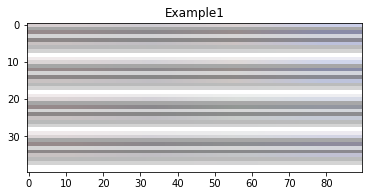

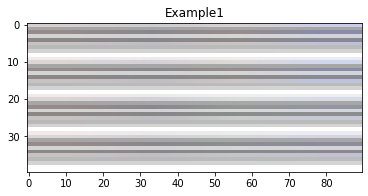

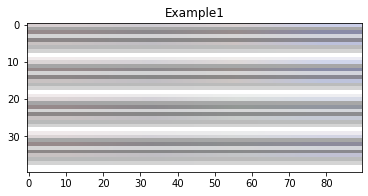

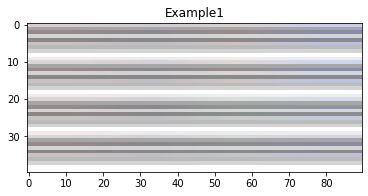

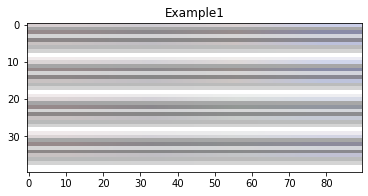

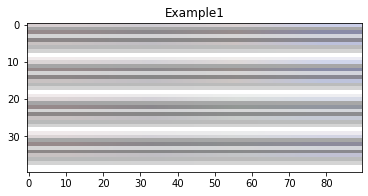

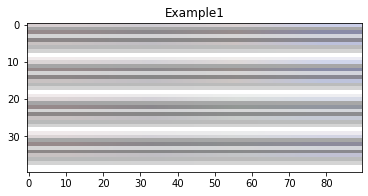

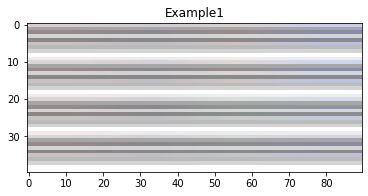

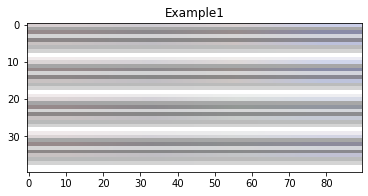

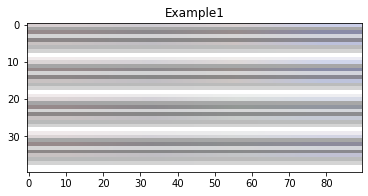

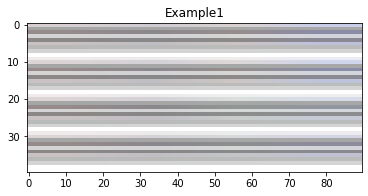

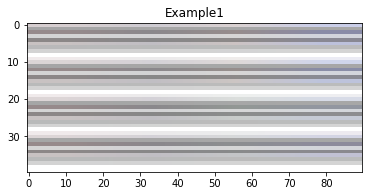

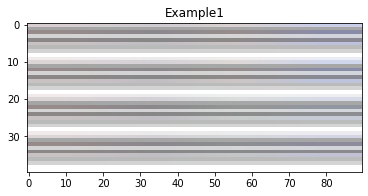

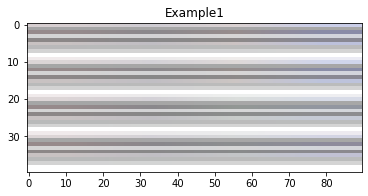

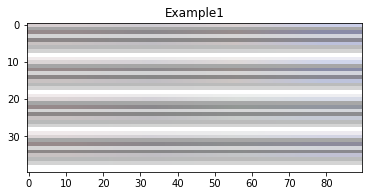

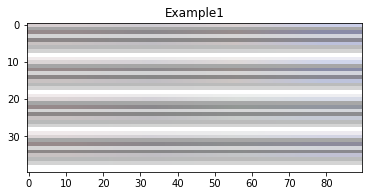

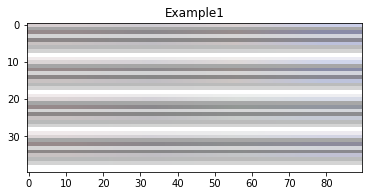

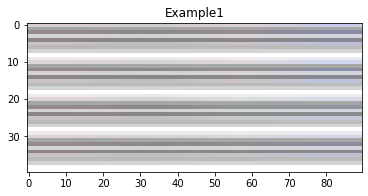

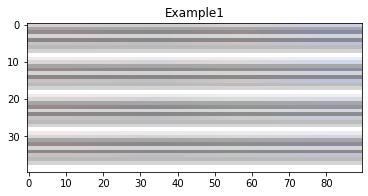

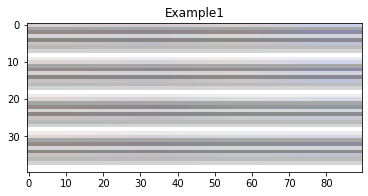

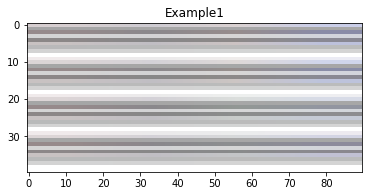

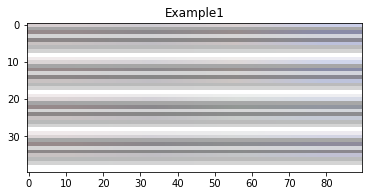

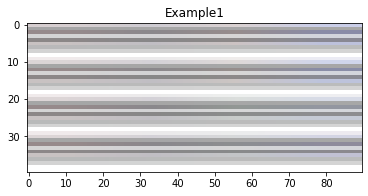

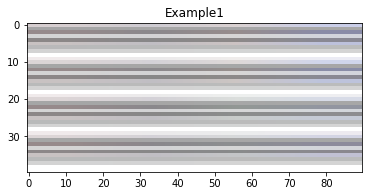

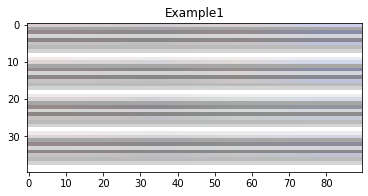

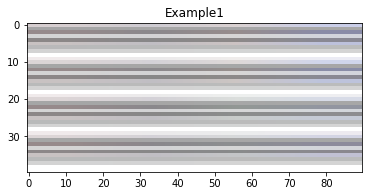

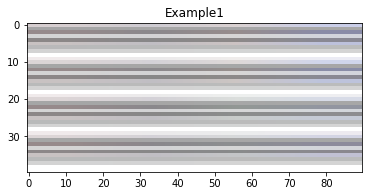

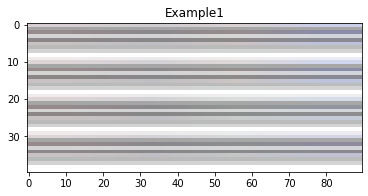

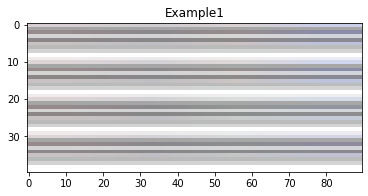

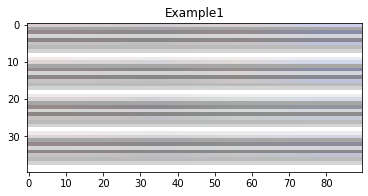

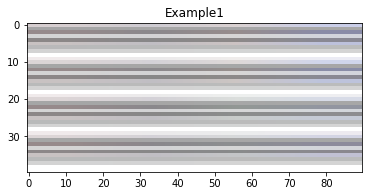

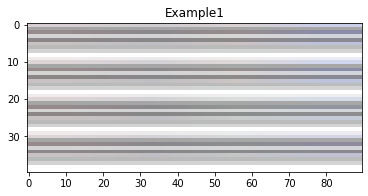

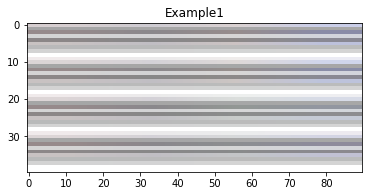

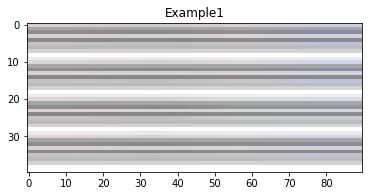

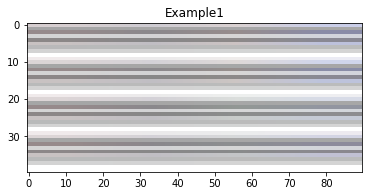

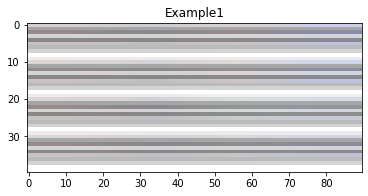

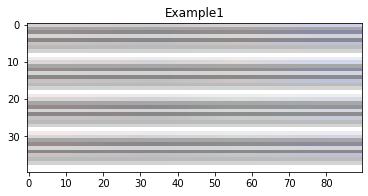

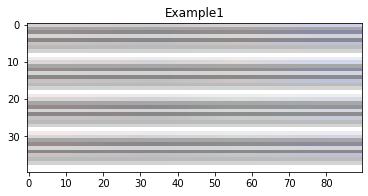

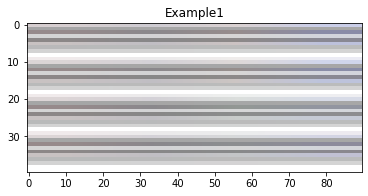

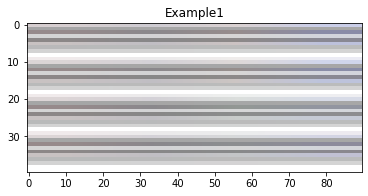

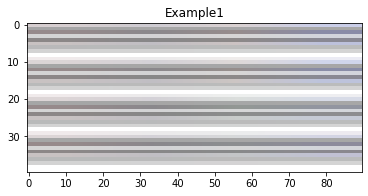

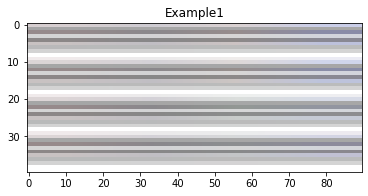

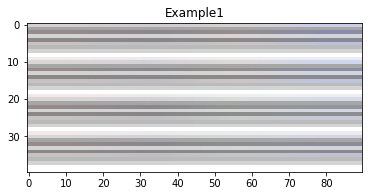

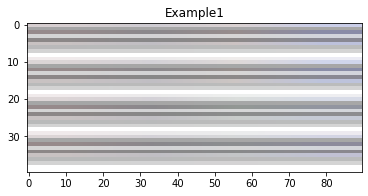

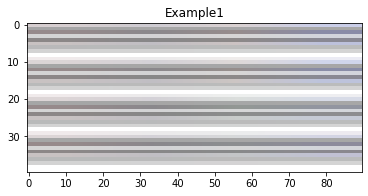

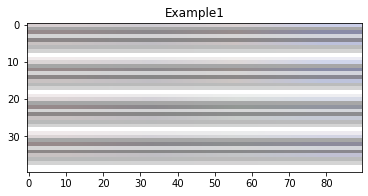

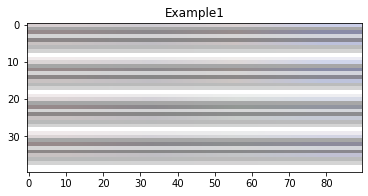

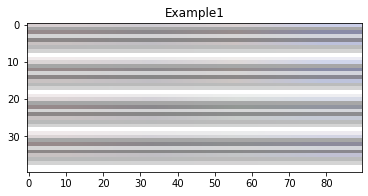

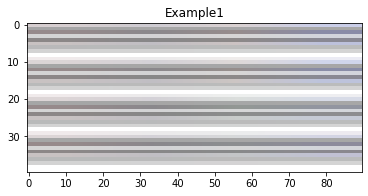

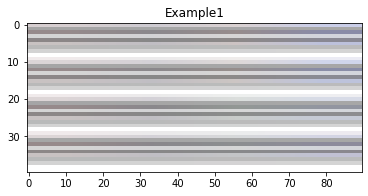

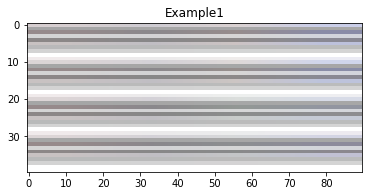

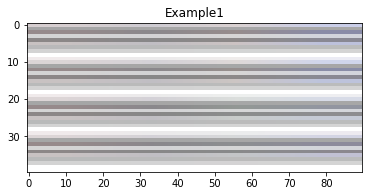

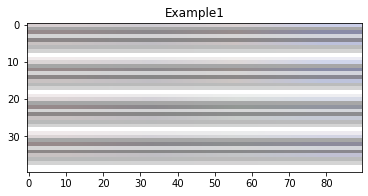

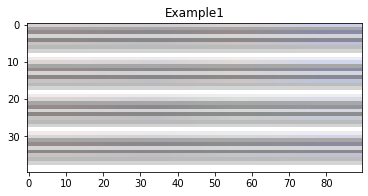

In [23]:
#screen method 2
bounding_box = {'top': 0, 'left': 200, 'width': 400, 'height': 300} #top left corner of screen
sct = mss()
while True:
    sct_img = sct.grab(bounding_box)
    cv2.imshow('screen', np.array(sct_img))
    sct_img1 = transform_screen_data(sct_img)
    plt.figure()
    plt.imshow(sct_img1.squeeze(0).permute(1,2,0),interpolation = 'none')
    plt.title("Example1")
    if (cv2.waitKey(1) & 0xFF) == ord('q'):
        cv2.destroyAllWindows()
        break

In [28]:
bounding_box = {'top': 0, 'left': 0, 'width': 400, 'height': 300} #top left corner of screen
sct = mss()
while True:
    sct_img = sct.grab(bounding_box)
    #np.array and np.float32 give diff answers
    gray = cv2.cvtColor(np.array(sct_img), cv2.COLOR_BGR2GRAY)
    cv2.imshow('screen', gray)
    if (cv2.waitKey(1) & 0xFF) == ord('q'):
        cv2.destroyAllWindows()
        break